In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pulp

In [64]:
#Load datasets
Weather_data = pd.read_csv('WeatherData.csv')
Energy_data = pd.read_csv('EnergyData.csv')

Energy_data.reset_index(drop=False, inplace=True)

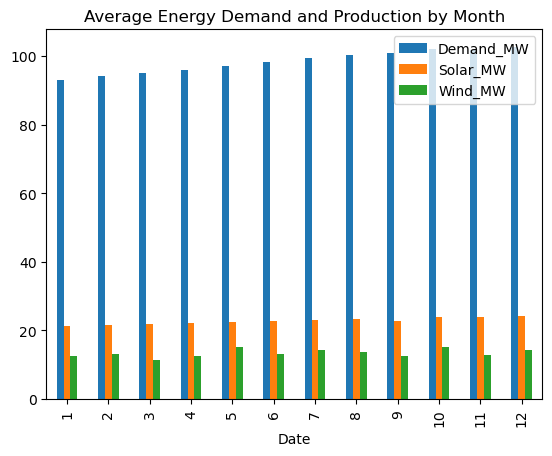

In [66]:
#Analyzing patterns in energy demand and production by month
Energy_data = Energy_data.loc[:, ~Energy_data.columns.duplicated()]
Energy_data['Date'] = pd.to_datetime(Energy_data['Date'])
Energy_data.set_index('Date', inplace=True)
Energy_data.groupby(Energy_data.index.month).mean().plot(
    kind='bar', y=['Demand_MW', 'Solar_MW', 'Wind_MW']
)
plt.title('Average Energy Demand and Production by Month')
plt.show()

<Axes: >

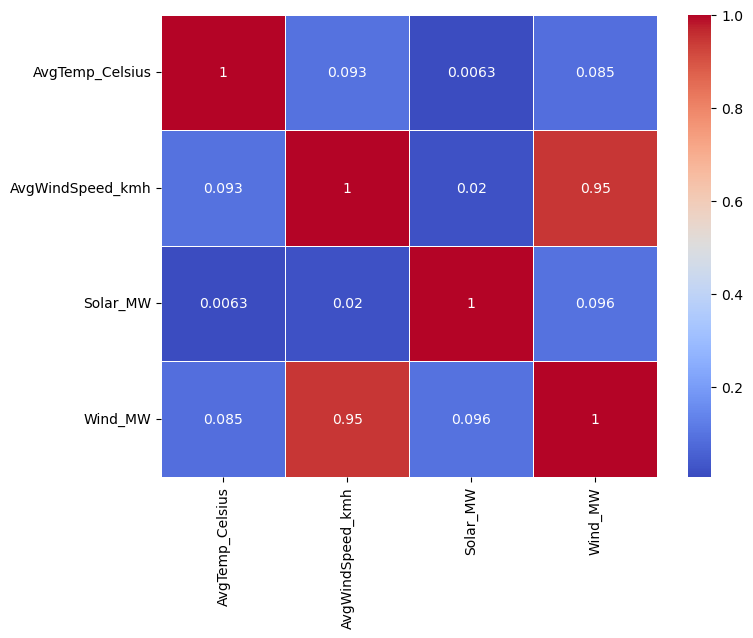

In [68]:
#Merge datasets and correlation analysis
#Reset index for merging
#Energy_data.reset_index(inplace=True)

Weather_data['Date'] = pd.to_datetime(Weather_data['Date'])

#Merge datasets on Date
merged_data = pd.merge(Energy_data, Weather_data, on='Date')

#Filter non_zero Solar energy production
merged_data = merged_data[merged_data['Solar_MW'] > 0]

#Correlation of Weather conditions and EnergyProduction
correlation = merged_data[[
    'AvgTemp_Celsius', 'AvgWindSpeed_kmh', 'Solar_MW', 'Wind_MW'
]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap='coolwarm',
            linewidths=.5)

In [85]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to calculate RMSE as a percentage
def rmse_percentage(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    percentage = (rmse / np.mean(y_true)) * 100
    return percentage

# Forecasting Energy Production and Demand
X = merged_data[['AvgTemp_Celsius', 'AvgWindSpeed_kmh']]
y_demand = merged_data['Demand_MW']
y_solar = merged_data['Solar_MW']
y_wind = merged_data['Wind_MW']

# Demand Forecasting Model
X_train, X_test, y_train, y_test = train_test_split(
    X, y_demand, test_size=0.2, random_state=42
)
demand_model = RandomForestRegressor(random_state=42)
demand_model.fit(X_train, y_train)
y_pred_demand = demand_model.predict(X_test)

# Setup for Solar and Wind Models 
solar_model = RandomForestRegressor(random_state=42)
wind_model = RandomForestRegressor(random_state=42)

# Align indices for X, y_solar, and y_wind
common_index = merged_data.dropna(subset=['Solar_MW', 'Wind_MW']).index
X = X.loc[common_index].reset_index(drop=True)
y_solar = y_solar.loc[common_index].reset_index(drop=True)
y_wind = y_wind.loc[common_index].reset_index(drop=True)

# Training and Predictions for Solar Energy
X_train_solar, X_test_solar, y_train_solar, y_test_solar = train_test_split(
    X, y_solar, test_size=0.2, random_state=42
)

# Training and Predictions for Wind Energy
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(
    X, y_wind, test_size=0.2, random_state=42
)

# Fit the models
solar_model.fit(X_train_solar, y_train_solar)
wind_model.fit(X_train_wind, y_train_wind)
y_pred_solar = solar_model.predict(X_test_solar)
y_pred_wind = wind_model.predict(X_test_wind)

# Correct Solar Predictions where actuals are zeros
actual_zeros = merged_data[merged_data['Solar_MW'] == 0].index
mask_zeros_in_actuals = X_test_solar.index.isin(actual_zeros)
y_pred_solar_corrected = np.where(
    mask_zeros_in_actuals, 0, y_pred_solar
)

# Calculate the RMSE for forecast including zero solar prediction
demand_rmse = rmse_percentage(y_test, y_pred_demand)
solar_rmse = rmse_percentage(y_test_solar, y_pred_solar_corrected)
wind_rmse = rmse_percentage(y_test_wind, y_pred_wind)

# Output RMSE percentages
print(f'Demand Forecast RMSE (%): {demand_rmse}')
print(f'Solar Production Forecast RMSE (%): {solar_rmse}')
print(f'Wind Production Forecast RMSE (%): {wind_rmse}')



Demand Forecast RMSE (%): 5.943996634938721
Solar Production Forecast RMSE (%): 9.011440280631595
Wind Production Forecast RMSE (%): 8.31763762351461


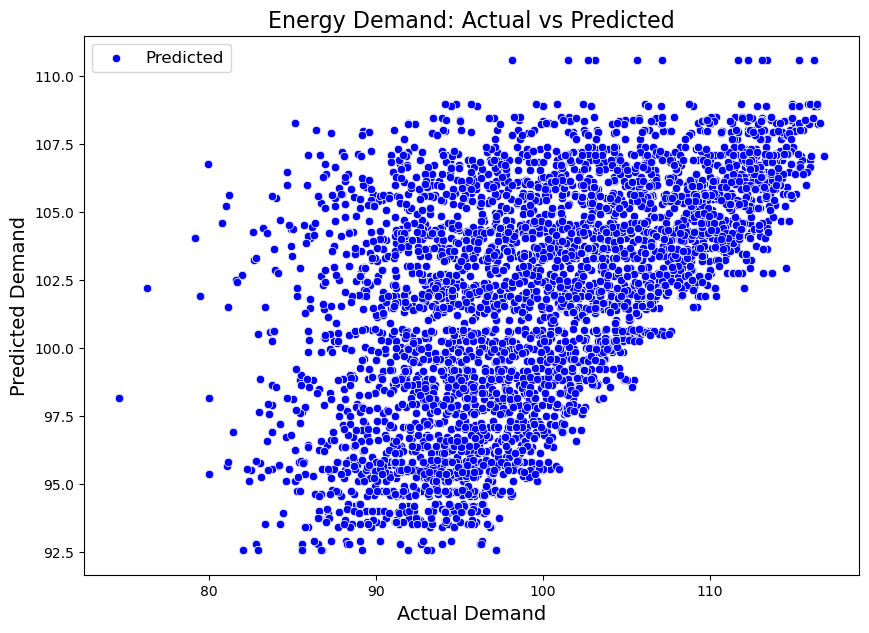

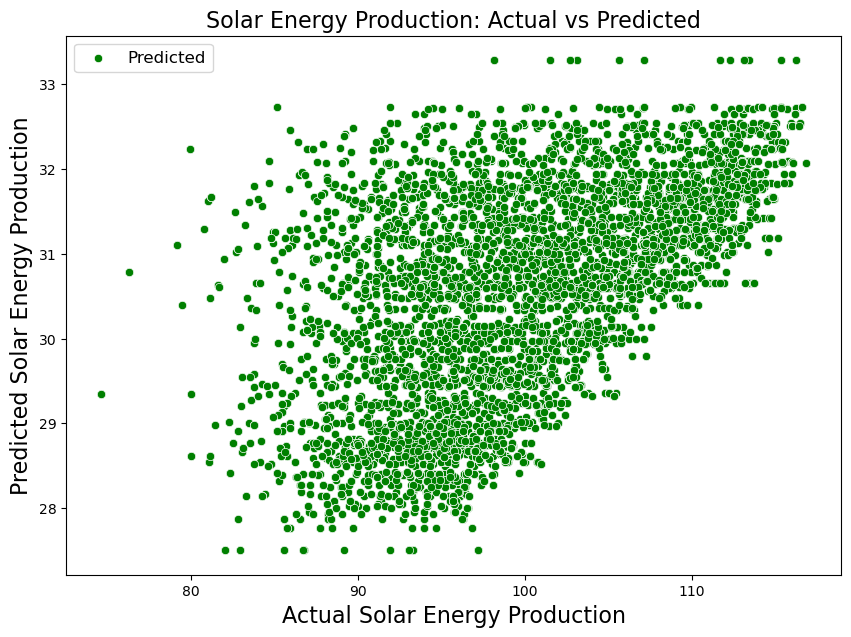

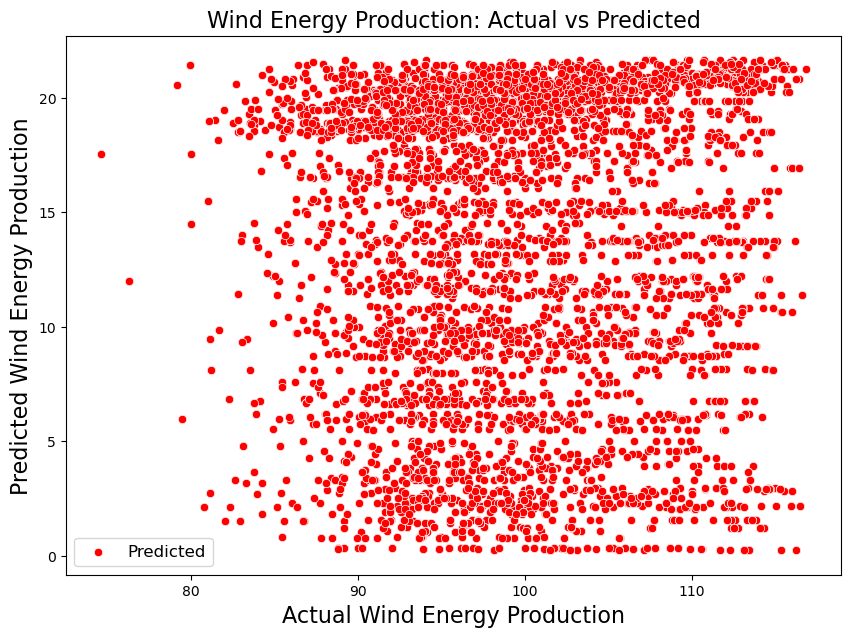

In [93]:
#Energy Demand visualization
plt.figure(figsize =(10,7))
sns.scatterplot(
    x=y_test, y=y_pred_demand, color='blue', label='Predicted'
)
plt.title(
    'Energy Demand: Actual vs Predicted', fontsize=16
)
plt.xlabel('Actual Demand', fontsize=14)
plt.ylabel('Predicted Demand', fontsize=14)
plt.legend(fontsize=12)
plt.show()

#Solar Energy Production Visualization
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=y_test, y=y_pred_solar, color='green', label='Predicted'
)
plt.title(
    'Solar Energy Production: Actual vs Predicted', fontsize=16
)
plt.xlabel('Actual Solar Energy Production', fontsize=16)
plt.ylabel('Predicted Solar Energy Production', fontsize=16)
plt.legend(fontsize=12)
plt.show()

#Wind Energy Production Visualization
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=y_test, y=y_pred_wind, color='red', label='Predicted'
)
plt.title(
    'Wind Energy Production: Actual vs Predicted', fontsize=16
)
plt.xlabel('Actual Wind Energy Production', fontsize=16)
plt.ylabel('Predicted Wind Energy Production', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [99]:
print(Energy_data.columns)


Index(['index', 'Hour', 'Demand_MW', 'Solar_MW', 'Wind_MW'], dtype='object')


In [101]:
# Assuming you have hourly data for each day, create a pseudo date index:
Energy_data['Date'] = pd.date_range(start='2024-01-01', periods=len(Energy_data), freq='H')

# Now resample and proceed
Energy_data_daily = Energy_data.set_index('Date').resample('D').mean()

# Apply SARIMAX
sarima_model = SARIMAX(
    Energy_data_daily['Demand_MW'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7)
)
sarima_results = sarima_model.fit(disp=False)
sarima_forecast = sarima_results.forecast(steps=7)

print('SARIMA Forecast for the next 7 days:')
print(sarima_forecast)


C:\Users\admin\AppData\Local\Temp\ipykernel_18592\1898126997.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Energy_data['Date'] = pd.date_range(start='2024-01-01', periods=len(Energy_data), freq='H')


SARIMA Forecast for the next 7 days:
2024-12-31    101.253215
2025-01-01    102.083830
2025-01-02    101.868741
2025-01-03    102.082024
2025-01-04    102.392969
2025-01-05    102.757868
2025-01-06    101.833059
Freq: D, Name: predicted_mean, dtype: float64


In [109]:
#Optimization with Pulp
average_solar_production_MWh_corrected = np.mean(y_pred_solar_corrected)
average_wind_production_MWh = np.mean(y_pred_wind)
average_demand_MWh = np.mean(y_pred_demand)

#Constants for impact assessment
grid_emission_factor = 0.5
solar_cost_per_kWh = 0.05
wind_cost_per_kWh = 0.07
natural_gas_cost_per_kWh = 0.15

#Define the optimization problem
problem = pulp.LpProblem('Energy_Optomization', pulp.LpMinimize)

#Update the supply variable to use the corrected solar production
grid_supply = pulp.LpVariable('Grid_Supply', lowBound=0)
solar_supply= pulp.LpVariable(
    'Solar_Supply',
    lowBound=0,
    upBound = average_solar_production_MWh_corrected
)
wind_supply = pulp.LpVariable(
    'Wind_Supply',
    lowBound = 0,
    upBound = average_wind_production_MWh
)
#Objective Function
problem += (
    solar_cost_per_kWh * solar_supply +
    wind_cost_per_kWh  * wind_supply  +
    natural_gas_cost_per_kWh * grid_supply,
    'Total Cost'
)
problem += (grid_supply + solar_supply + wind_supply >= average_demand_MWh,
            'Demand_Meeting'
           )
problem.solve()
#Check solution status
if pulp.LpStatus[problem.status] =='Optimal':
    print(f'Optimal grid supply: {grid_supply.varValue} MW')
    print(f'Optimal solar supply: {solar_supply.varValue} MW')
    print(f'Optimal wind supply: {wind_supply.varValue} MW')
else:
    print('Optimization did not find a feasible solution')


Optimal grid supply: 57.255913 MW
Optimal solar supply: 30.375534 MW
Optimal wind supply: 13.626215 MW


Emissions Saved :22.0008745 kg C02
Economic Savings: $4.12765066811288


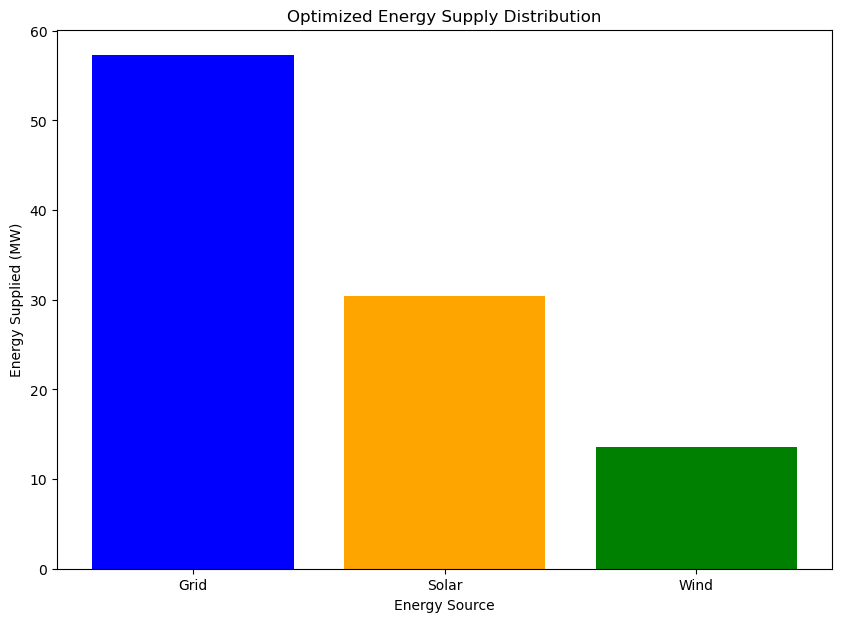

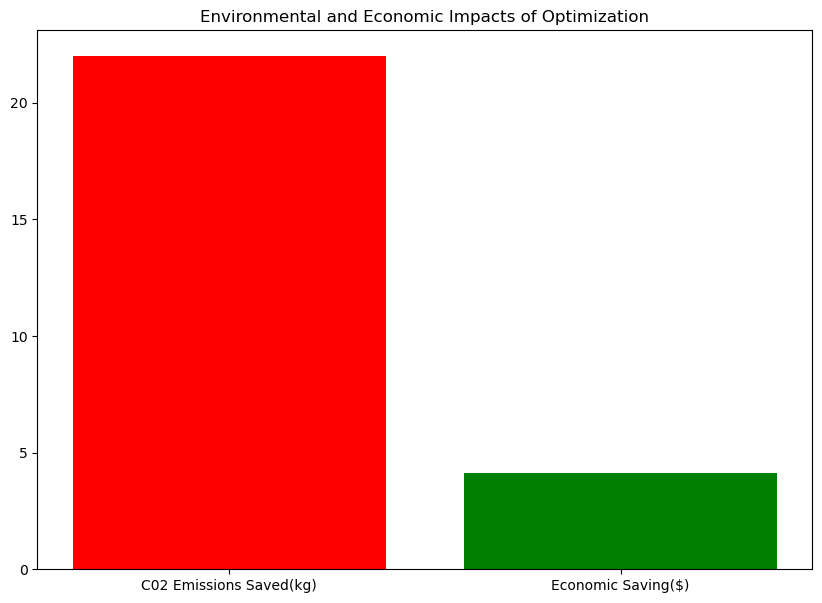

In [129]:
#Impact assessment and visualization
emissions_saved_kg = (
    solar_supply.varValue + wind_supply.varValue
) * grid_emission_factor
cost_with_gas = average_demand_MWh * natural_gas_cost_per_kWh
cost_with_optimization = pulp.value(problem.objective)
savings = cost_with_gas - cost_with_optimization

print(f'Emissions Saved :{emissions_saved_kg} kg C02')
print(f'Economic Savings: ${savings}')

#Visualization
plt.figure(figsize = (10,7))
plt.bar(
    ['Grid', 'Solar', 'Wind'],
    [grid_supply.varValue, solar_supply.varValue, wind_supply.varValue],
    color = ['blue', 'orange', 'green']
)
plt.title('Optimized Energy Supply Distribution')
plt.xlabel('Energy Source')
plt.ylabel('Energy Supplied (MW)')
plt.show()
plt.figure(figsize=(10,7))
plt.bar(
    ['C02 Emissions Saved(kg)', 'Economic Saving($)'],
    [emissions_saved_kg, savings],
    color =['red', 'green']
)
plt.title('Environmental and Economic Impacts of Optimization')
plt.show()